In [1]:
!pip install livelossplot


In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
#from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
#from hyperopt.pyll import scope
from tensorflow.keras.layers import Normalization
import pickle
from scipy.signal import savgol_filter
from scipy.signal import savgol_coeffs
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import scale
from livelossplot import PlotLossesKerasTF
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv1D, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
tfd = tfp.distributions

In [5]:
kiwi = pd.read_csv('/data/kiwifruit_dat.csv')
kiwi = kiwi.dropna(subset=['SSC'])
kiwi = kiwi[kiwi['DM'] > 7]
kiwi['Date'] = pd.to_datetime(kiwi['Date'], format='%d/%m/%Y')
kiwi = kiwi.sort_values(
    by=['Date'],  # Specify the sorting columns
    kind='stable'
)

y_var='DM'
x_lower='X459'
x_upper='X1062'
cols = kiwi.columns[kiwi.columns.slice_indexer(x_lower,x_upper)]
kiwi=kiwi.dropna(subset=cols)
# Display the first few rows of the filtered DataFrame
display(kiwi.head())

# Display the number of unique sample_ids before and after filtering
print(f"Number of unique sample_ids before filtering: {kiwi['sample_id'].nunique()}")


,Dataset,Date,device,sample_id,SSC,DM,X402,X405,X408,X411,...,X1110,X1113,X1116,X1119,X1122,X1125,X1128,X1131,X1134,X1137
0,Training,2017-03-28,KK1,1,10.2,15.7,0.0,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Training,2017-03-28,KK2,1,10.2,15.7,0.0,0.0,0.0,1.036350,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Training,2017-03-28,TP1,1,10.2,15.7,0.0,0.0,0.0,0.752586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Training,2017-03-28,TP2,1,10.2,15.7,0.0,0.0,0.0,1.138167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Training,2017-03-28,TP3,1,10.2,15.7,0.0,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Number of unique sample_ids before filtering: 5416


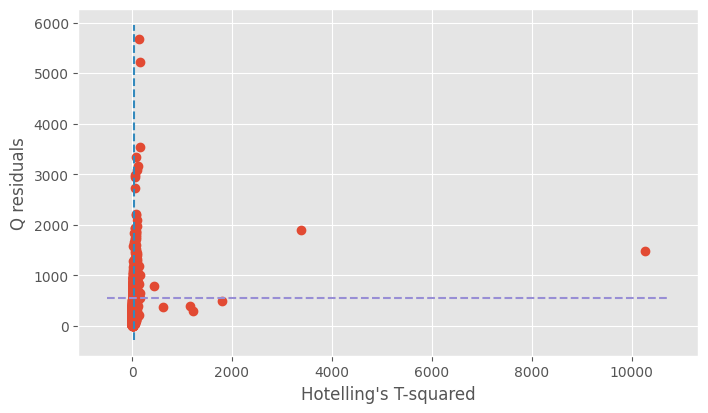

In [6]:
target=kiwi.loc[(~kiwi.Dataset.isin(["Test"])),y_var]
features = kiwi.loc[(~kiwi.Dataset.isin(["Test"])),x_lower:x_upper]

import sklearn.cross_decomposition as skl
ncomp=20
pls = skl.PLSRegression(n_components=ncomp)
# Fit data
#pls.fit(normalized_features, target_dm)
pls.fit(features, target)

# Get X scores
T = pls.x_scores_
# Get X loadings
P = pls.x_loadings_
# Calculate error array
Err = features - np.dot(T,P.T)
# Calculate Q-residuals (sum over the rows of the error array)
Q = np.sum(Err**2, axis=1)
# Calculate Hotelling's T-squared (note that data are normalised by default)
Tsq = np.sum((pls.x_scores_/np.std(pls.x_scores_, axis=0))**2, axis=1)

# set the confidence level
conf = 0.95
from scipy.stats import f
# Calculate confidence level for T-squared from the ppf of the F distribution
Tsq_conf =  f.ppf(q=conf, dfn=ncomp, \
            dfd=features.shape[0])*ncomp*(features.shape[0]-1)/(features.shape[0]-ncomp)
# Estimate the confidence level for the Q-residuals
i = np.max(Q)+1
while 1-np.sum(Q>i)/np.sum(Q>0) > conf:
    i -= 1
Q_conf = i

import matplotlib.pyplot as plt
ax = plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(Tsq, Q, 'o')
    plt.plot([Tsq_conf,Tsq_conf],[plt.axis()[2],plt.axis()[3]],  '--')
    plt.plot([plt.axis()[0],plt.axis()[1]],[Q_conf,Q_conf],  '--')
    plt.xlabel("Hotelling's T-squared")
    plt.ylabel('Q residuals')
plt.show()

In [7]:
#kiwi.iloc[~(kiwi.Dataset.isin(["Test"]),:].drop
#kiwi.iloc[~(kiwi.Dataset.isin(["Test"])),:].drop((Q<1500) | (Tsq<500))
in_index=kiwi[~(kiwi.Dataset.isin(["Test"]))].index[((Q<1200) & (Tsq<500))]
test_index=kiwi[(kiwi.Dataset.isin(["Test"]))].index
kiwi=kiwi.loc[np.concatenate((in_index,test_index)),:]

features_train = kiwi.loc[(kiwi.Dataset.isin(["Training"])),x_lower:x_upper]
features_val = kiwi.loc[(kiwi.Dataset.isin(["Validation"])),x_lower:x_upper]
features_test = kiwi.loc[(kiwi.Dataset.isin(["Test"])),x_lower:x_upper]
target_train = kiwi.loc[(kiwi.Dataset.isin(["Training"])),y_var]
target_val = kiwi.loc[(kiwi.Dataset.isin(["Validation"])),y_var]
target_test = kiwi.loc[(kiwi.Dataset.isin(["Test"])),y_var]



features_train_norm=(features_train-features_train.mean())/features_train.std()
features_val_norm=(features_val-features_train.mean())/features_train.std()
features_test_norm=(features_test-features_train.mean())/features_train.std()

In [8]:
from scipy.signal import savgol_filter
from scipy.signal import savgol_coeffs
deriv=2
polyo=2
width=13

X_train_norm_sg = savgol_filter(features_train_norm, width, polyorder = polyo,deriv=deriv)
X_val_norm_sg = savgol_filter(features_val_norm, width, polyorder = polyo,deriv=deriv)
X_test_norm_sg = savgol_filter(features_test_norm, width, polyorder = polyo,deriv=deriv)

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define the PCA object
pca = PCA()

# Run PCA on scaled data and obtain the scores array
T = pca.fit_transform(StandardScaler().fit_transform(X_test_norm_sg))

{'whiskers': [<matplotlib.lines.Line2D at 0x7ea42812c6e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ea42812d9a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ea428107ec0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ea42812e1e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ea42812e510>],
 'means': []}

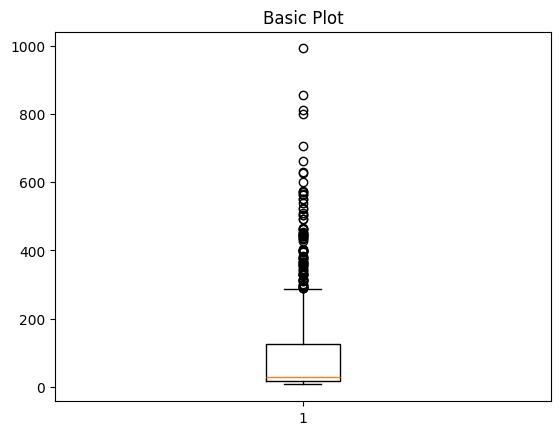

In [10]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet
robust_cov  = MinCovDet().fit(T[:,:20])

# Get the Mahalanobis distance
m  = robust_cov.mahalanobis(T[:,:20])

fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(m[m<1000])

In [11]:
target_test=target_test[m<800]
features_test=features_test.loc[m<800,:]
features_test_norm=(features_test-features_train.mean())/features_train.std()

Utility functions

In [13]:


def cov_transform_tf(x,target_mean,target_cov):
    #x = x.astype('float32')
    idx=tf.range(0,tf.shape(x)[1])
    ind=tf.random.shuffle(idx)
    ind_inv=tf.argsort(ind)
    cov_x=tfp.stats.covariance(x)
    cov_x_shuff=tf.gather(cov_x, ind,axis=1)
    cov_t_shuff=tf.gather(target_cov, ind,axis=1)
    cov_x_shuff=tf.gather(cov_x_shuff, ind,axis=0)
    cov_t_shuff=tf.gather(cov_t_shuff, ind,axis=0)
    c0 = tf.linalg.cholesky(cov_x_shuff)

    c1 = tf.linalg.cholesky(cov_t_shuff)
    c_shuff = tf.matmul(c1,tf.linalg.inv(c0))
    c=tf.gather(c_shuff, ind_inv,axis=1)
    c=tf.gather(c, ind_inv,axis=0)
    obs_mean = tf.math.reduce_mean(x,axis=0)[None,:]
    obs_cov = tfp.stats.covariance(x)
    offset=target_mean-tf.transpose((tf.matmul(c,tf.transpose(obs_mean))))
    x_transform=tf.transpose((tf.matmul(c,tf.transpose(x))))+offset
    return x_transform




def get_samp_dist(X,kiwi):
    #obs_cov = np.cov(X, rowvar=False)
    #obs_mean = np.mean(X,axis=0,dtype=np.float64)
    obs_mean1 = tf.math.reduce_mean(X,axis=0)[None,:]
    obs_cov1 = tfp.stats.covariance(X)
    chol_scale = tf.linalg.cholesky(obs_cov1)  # Shape is [3, 3].
    dist = tfd.WishartTriL(kiwi=kiwi, scale_tril=chol_scale)
    mvn = tfd.MultivariateNormalFullCovariance(
    loc=obs_mean1,
    covariance_matrix=obs_cov1/kiwi)
    return mvn, dist


def aug_dat(X,Y,kiwi):
    #X = X.astype('float32')
    A, B = get_samp_dist(X,kiwi)
    sample_mean = A.sample()
    sample_cov = B.sample()/kiwi
    x_trans=cov_transform_tf(X,sample_mean,sample_cov)
    return x_trans, Y

In [14]:
def noise_dat(X,Y,kiwi):
    chi_d = tfd.Chi(df=kiwi)
    rchi=tf.divide(chi_d.sample(tf.shape(X)),tf.sqrt(kiwi))
    cent=tf.math.reduce_mean(X, axis=0)
    X_cent = tf.math.add(X,-cent)
    sd=tf.math.reduce_std(X, axis=0)
    #scale=tf.matmul(rchi,tf.linalg.diag(sd))
    #mean_dist = tfd.MultivariateNormalTriL(
    #loc=cent,
    #scale_tril=tf.linalg.cholesky(tf.pow(tf.linalg.diag(sd),2)/kiwi))
    mean_dist = tfd.MultivariateNormalFullCovariance(
    loc=cent,
    covariance_matrix=tf.pow(tf.linalg.diag(sd),2)/kiwi)
    sample_mean = mean_dist.sample(len(X))
    X_noisey=tf.math.add(tf.math.multiply(X_cent,rchi),sample_mean)
    return X_noisey, Y


def noise_data(BATCH_SIZE,n_epochs):
    dataset = tf.data.Dataset.from_tensor_slices((features_train_norm.values.astype('float32'), train_pred))
    dataset_test = tf.data.Dataset.from_tensor_slices((features_test_norm.values.astype('float32'), validate_pred))
    train_dataset = dataset

    #dataset = dataset.shuffle(len(dataset),reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(1)
    dataset = dataset.batch(BATCH_SIZE)
    dataset_test=dataset_test.batch(BATCH_SIZE)
    tf.random.Dataset_seed(12)
    train_dataset_aug = (
            dataset.map(
                lambda x, y: (
                   noise_dat(x,y,1000.)
                )
            ).repeat(n_epochs)
    )
    test_dataset_aug = (
            dataset_test.map(
                lambda x, y: (
                   noise_dat(x,y,1000.)
                )
            ).repeat(n_epochs)
    )
    return train_dataset_aug, test_dataset_aug

In [15]:
def diffeo_data(BATCH_SIZE,n_epochs):
    dataset = tf.data.Dataset.from_tensor_slices((features_train_norm.values, train_pred))
    dataset_test = tf.data.Dataset.from_tensor_slices((features_test_norm.values, validate_pred))
    train_dataset = dataset

    #dataset = dataset.shuffle(len(dataset),reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(1)
    dataset = dataset.batch(BATCH_SIZE)
    dataset_test=dataset_test.batch(BATCH_SIZE)
    tf.random.Dataset_seed(12)
    train_dataset_aug = (
            dataset.map(
                lambda x, y: (
                   aug_dat(x,y,1000)
                )
            ).repeat(n_epochs)
    )
    test_dataset_aug = (
            dataset_test.map(
                lambda x, y: (
                   aug_dat(x,y,1000)
                )
            ).repeat(n_epochs)
    )
    return train_dataset_aug, test_dataset_aug

In [16]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, mode='auto', restore_best_weights=True)
#
### 2) Reduce learning rate dynamically
rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=0)
### 3) Save the best weights into file
checkpointer= keras.callbacks.ModelCheckpoint(filepath="model_weights.h5", verbose=1, save_best_only=True)

In [17]:
def build_model(num_layers=4,conv1=1.,units=(128,64,32,16),n_filt=1,kernel_size=13,act="relu",l2=0.0,preprocess=0):
    """
    Builds model and sets up hyperparameter space to search.

    Parameters
    ----------
    hp : HyperParameter object
        Configures hyperparameters to tune.

    Returns
    -------
    model : keras model
        Compiled model with hyperparameters to tune.
    """
    # Initialize sequential API and start building model.
    model = keras.Sequential()
    model.add(tf.keras.layers.Reshape((202, 1), input_shape=(202,)))

    if preprocess >0.0:
        sg=savgol_coeffs(13, 2, deriv=(preprocess-1), use='conv')
        model.add(tf.keras.layers.Conv1D(filters=1,strides=1,kernel_size=13,padding='same', activation='linear',kernel_initializer=tf.keras.initializers.HeUniform(),use_bias=False))
        model.layers[1].set_weights(np.array([np.expand_dims(np.transpose(np.array([sg])),axis=1)]))
        model.layers[1].trainable = False

    # Tune the number of hidden layers and units in each.
    # Number of hidden layers: 1 - 5
    # Number of Units: 32 - 512 with stepsize of 32
    if conv1 >0.0:
        model.add(tf.keras.layers.Conv1D(filters=n_filt,strides=1,kernel_size=13,padding='same', activation='linear',kernel_initializer=tf.keras.initializers.HeUniform(),use_bias=False))

    model.add(tf.keras.layers.Flatten())

    for i in range(0, num_layers):
        model.add(
            keras.layers.Dense(
                units=units[i],
                activation=act,kernel_regularizer=tf.keras.regularizers.l2(l2)))

    # Add output layer.
    model.add(keras.layers.Dense(units=1, activation="linear"))


    print('Adam learning rate = {}'.format(LR))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='mse', metrics=['mae'])
    return model

## Train a model

In [18]:
import random
n_neur=np.sort((random.sample(range(1, 100), 4)))[::-1]
n_dense=random.sample(range(1, 4), 1)
r_act=random.sample(["relu","elu"],1)
n_filt=(random.sample(range(1, 50),1))[0]
kernel_size=(random.sample(range(7, 50),1))[0]
BATCH=256
LR=0.01*BATCH/256.
test_model=build_model(num_layers=n_dense[0],n_filt=n_filt,kernel_size=kernel_size,units=n_neur,act="relu",l2=0.0,preprocess=1)

#"/Users/George/Desktop/file_{0}layers_{1}_{2}_{3}_{4}_act_{5}.bmp".format(n_dense[0],n_neur[0],n_neur[1],n_neur[2],n_neur[3],r_act[0])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Adam learning rate = 0.01


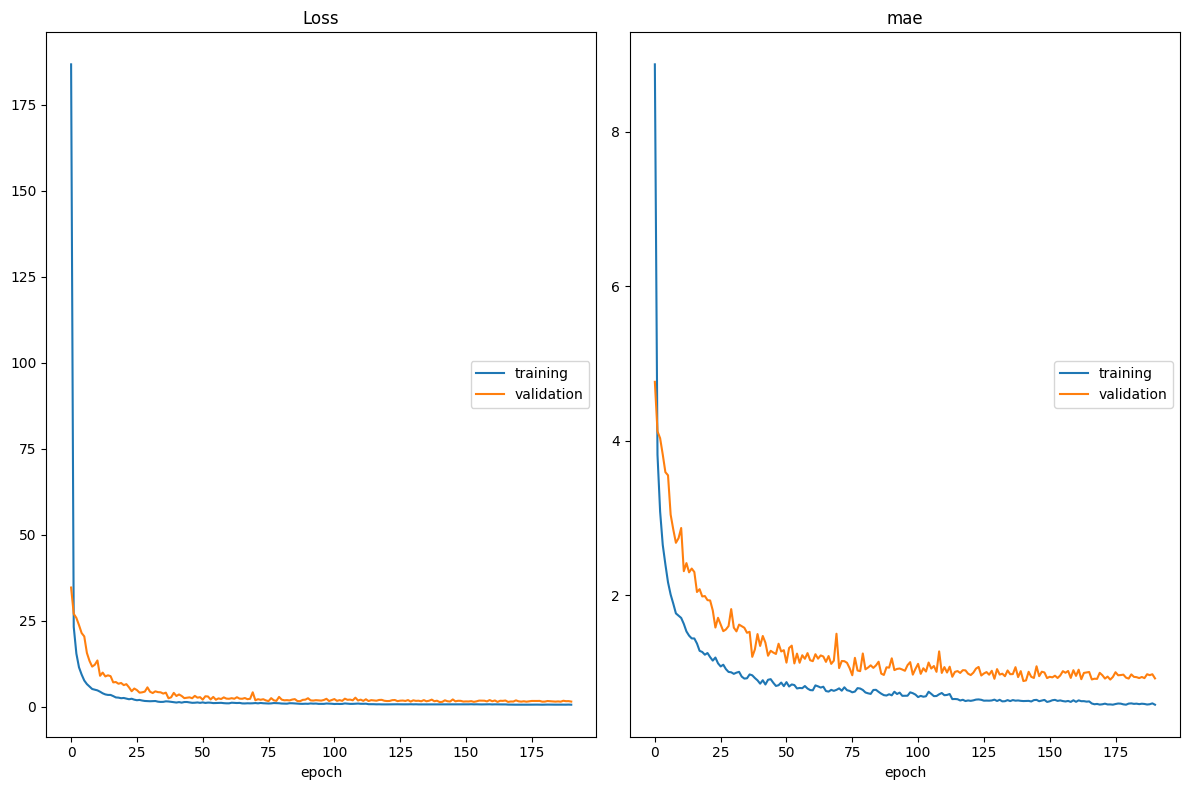

Loss
	training         	 (min:    0.584, max:  186.747, cur:    0.584)
	validation       	 (min:    1.366, max:   34.645, cur:    1.491)
mae
	training         	 (min:    0.586, max:    8.873, cur:    0.586)
	validation       	 (min:    0.892, max:    4.764, cur:    0.927)

Epoch 191: val_loss did not improve from 1.36579
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6057 - mae: 0.5934 - val_loss: 1.4913 - val_mae: 0.9268 - learning_rate: 0.0025


In [19]:
plot_losses = PlotLossesKerasTF()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, mode='auto', restore_best_weights=True)
#
### 2) Reduce learning rate dynamically
rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=0)
### 3) Save the best weights into file
checkpointer= keras.callbacks.ModelCheckpoint(filepath="model_weights.h5", verbose=1, save_best_only=True)

## Train the model
test_model.fit(features_train_norm, target_train, batch_size=BATCH, epochs=1500, \
          validation_data=(features_val_norm, target_val),  \
          callbacks=[plot_losses, checkpointer,early_stop,rdlr],verbose=1)

tf.keras.backend.clear_session()

In [20]:
def williams(trt):
    if not isinstance(trt, int) or trt < 2:
        raise ValueError("Number of treatments is not an integer >1.")
    if trt == 2:
        design = np.array([[1, 2], [2, 1]])
    if trt > 2:
        gen_row = np.concatenate(([0], np.ones(trt - 1)))
        a = np.where(np.arange(3, trt+1) % 2 == 0, -1, 1)
        for i in range(3, trt+1):
            gen_row[i - 1] = gen_row[i - 2] + a[i - 3] * (trt + 1 - i)
        design = np.vstack((gen_row, np.zeros((trt - 1, trt))))
        for i in range(1, trt):
            design[i, :] = (design[i - 1, :] + 1) % trt
        design += 1
        if trt % 2 == 1:
            design = np.vstack((design, np.apply_along_axis(np.flip, 1, design)))
    return design-1

In [21]:
def gamma_mean(x,i):
    if x - i + 2 < 150:
      # Calculate mean of gamma
      y = (gamma((x - i + 2) / 2) / gamma((x - i + 1) / 2) * tf.math.sqrt(2 / x))
    else:
      # Calculate mean using approx for large N
      y = (tf.pow((x - i) / 2, 2) + (x - i) / 4 + 1 / 8) ** (1 / 4) * tf.math.sqrt(2 / x)
    return y

def gamma_var(x,i):
    if x - i + 2 < 150:
      # Calculate gamma var
      y = (x-i+1)/x-tf.pow(gamma((x - i + 2) / 2) / gamma((x - i + 1) / 2) * tf.math.sqrt(2 / x),2)
    else:
      # Calculate var using approx for large N
      y = (x-i+1)/x-tf.pow((tf.pow((x - i) / 2, 2) + (x - i) / 4 + 1 / 8) ** (1 / 4) * tf.math.sqrt(2 / x),2)
    return y

In [29]:
def Diffeo_data_ind(x1,cov_x,df,ind):
    #cov_x = cov_x[ind,ind]
    cov_x = tf.gather(cov_x, ind,axis=1)
    cov_x = tf.gather(cov_x, ind,axis=0)
    #x1 = tf.cast(x1, tf.float64)
    #cov_x = tf.cast(cov_x, tf.float64)
    x1 = x1[:,ind]
    ind_inv=np.argsort(ind)
    c0=tf.linalg.cholesky(cov_x)
    c0_inv=tf.linalg.inv(c0)
    tensor_mean=tf.zeros(cov_x.shape)
    tensor_mean=tf.linalg.band_part(tensor_mean, -1, 0)
    tensor_mean = tf.linalg.set_diag(tensor_mean,np.vectorize(gamma_mean)(np.repeat(df,tensor_mean.shape[1]),np.arange(1,tensor_mean.shape[1]+1,1)))
    x1_mean = tf.matmul(tf.matmul(c0, tensor_mean), tf.matmul(c0_inv, tf.transpose(x1)))
    tensor_var=tf.ones(cov_x.shape)/df
    tensor_var_var=tf.linalg.band_part(tensor_var, -1, 0)
    tensor_var = tf.linalg.set_diag(tensor_var,np.vectorize(gamma_var)(np.repeat(df,tensor_var.shape[1]),np.arange(1,tensor_var.shape[1]+1,1)))
    x1_var = tf.matmul(tf.matmul(tf.pow(c0,2), tensor_var), tf.pow(tf.matmul(tf.linalg.inv(c0), tf.transpose(x1)),2))
    tensor=tf.random.normal(cov_x.shape)/np.sqrt(df)
    tensor=tf.linalg.band_part(tensor, -1, 0)
    chi_d = tfd.Chi(df=np.arange(df,df-tensor.shape[1],-1.).astype('float32'))
    # Set the upper triangle of Bvar to zero
    tensor = tf.linalg.set_diag(tensor,chi_d.sample(1)[0])
    x1_diffeo = tf.matmul(tf.matmul(c0, tensor), tf.matmul(tf.linalg.inv(c0), tf.transpose(x1)))
    x1_random = tf.random.normal(x1_mean.shape,mean=x1_mean,stddev=tf.sqrt(x1_var))
    return tf.gather(tf.transpose(x1_diffeo)/np.sqrt(df),ind_inv,axis=1), tf.gather(tf.transpose(x1_random),ind_inv,axis=1)

In [23]:
def Diffeo_data_ind(x1,cov_x,kiwi,ind):
    #cov_x = cov_x[ind,ind]
    #cov_x = tf.gather(cov_x, ind,axis=1)
    cov_x = tf.gather(cov_x, ind,axis=0)
    x1 = x1[:,ind]
    ind_inv=np.argsort(ind)
    c0=tf.linalg.cholesky(cov_x)
    c0_inv=tf.linalg.inv(c0)
    tensor_mean=tf.zeros(cov_x.shape)
    tensor_mean=tf.linalg.band_part(tensor_mean, -1, 0)
    # Explicitly cast to tf.float32
    #tensor_mean = tf.linalg.diag(tf.cast(np.vectorize(gamma_mean)(np.repeat(kiwi,tensor_mean.shape[1]),np.arange(1,tensor_mean.shape[1]+1,1)), tf.float32))
    tensor_mean = tf.linalg.set_diag(tensor_mean,np.vectorize(gamma_mean)(np.repeat(kiwi,tensor_mean.shape[1]),np.arange(1,tensor_mean.shape[1]+1,1)))
    x1_mean = tf.matmul(tf.matmul(c0, tensor_mean), tf.matmul(c0_inv, tf.transpose(x1)))
    tensor_var=tf.ones(cov_x.shape)/kiwi
    tensor_var_var=tf.linalg.band_part(tensor_var, -1, 0)
    tensor_var = tf.linalg.set_diag(tensor_var,np.vectorize(gamma_var)(np.repeat(kiwi,tensor_var.shape[1]),np.arange(1,tensor_var.shape[1]+1,1)))
    # Explicitly cast to tf.float32
    #tensor_var = tf.linalg.diag(tf.cast(np.vectorize(gamma_var)(np.repeat(kiwi,tensor_var.shape[1]),np.arange(1,tensor_var.shape[1]+1,1)), tf.float32))
    # x1_var = tf.matmul(tf.matmul(tf.pow(c0,2), tensor_var), tf.pow(tf.matmul(tf.linalg.inv(c0), tf.transpose(x1)),2))
    tensor=tf.random.normal(cov_x.shape)/np.sqrt(kiwi)
    tensor=tf.linalg.band_part(tensor, -1, 0)
    chi_d = tfd.Chi(df=np.arange(kiwi,kiwi-tensor.shape[1],-1.).astype('float32'))
    # Set the upper triangle of Bvar to zero
    tensor = tf.linalg.diag(chi_d.sample(1)[0])
    x1_diffeo = tf.matmul(tf.matmul(c0, tensor), tf.matmul(tf.linalg.inv(c0), tf.transpose(x1)))
    # x1_var is not defined if the commented line is not used. Placeholder for now.
    x1_var = tf.matmul(tf.matmul(tf.pow(c0,2), tensor_var), tf.pow(tf.matmul(tf.linalg.inv(c0), tf.transpose(x1)),2))
    x1_random = tf.random.normal(x1_mean.shape,mean=x1_mean,stddev=tf.sqrt(x1_var))
    return tf.gather(tf.transpose(x1_diffeo)/np.sqrt(kiwi),ind_inv,axis=1), tf.gather(tf.transpose(x1_random),ind_inv,axis=1)

In [30]:
def Diffeo_data_ind(x1,cov_x,df,ind):
    #cov_x = cov_x[ind,ind]
    cov_x = tf.gather(cov_x, ind,axis=1)
    cov_x = tf.gather(cov_x, ind,axis=0)
    x1 = x1[:,ind]
    ind_inv=np.argsort(ind)
    c0=tf.linalg.cholesky(cov_x)
    c0_inv=tf.linalg.inv(c0)
    tensor_mean=tf.zeros(cov_x.shape)
    tensor_mean = tf.linalg.set_diag(tensor_mean,np.vectorize(gamma_mean)(np.repeat(df,tensor_mean.shape[1]),np.arange(1,tensor_mean.shape[1]+1,1)))
    tensor_mean=tf.linalg.band_part(tensor_mean, -1, 0)
    x1_mean = tf.matmul(tf.matmul(c0, tensor_mean), tf.matmul(c0_inv, tf.transpose(x1)))
    tensor_var=tf.ones(cov_x.shape)/df
    tensor_var = tf.linalg.set_diag(tensor_var,np.vectorize(gamma_var)(np.repeat(df,tensor_var.shape[1]),np.arange(1,tensor_var.shape[1]+1,1)))
    tensor_var=tf.linalg.band_part(tensor_var, -1, 0)
    x1_var = tf.matmul(tf.matmul(tf.pow(c0,2), tensor_var), tf.pow(tf.matmul(tf.linalg.inv(c0), tf.transpose(x1)),2))
    tensor=tf.random.normal(cov_x.shape)
    tensor=tf.linalg.band_part(tensor, -1, 0)
    chi_d = tfd.Chi(df=np.arange(df,df-tensor.shape[1],-1.).astype('float32'))
    # Set the upper triangle of Bvar to zero
    tensor = tf.linalg.set_diag(tensor,chi_d.sample(1)[0])
    x1_diffeo = tf.matmul(tf.matmul(c0, tensor/np.sqrt(df)), tf.matmul(tf.linalg.inv(c0), tf.transpose(x1)))
    x1_random = tf.random.normal(x1_mean.shape,mean=x1_mean,stddev=tf.sqrt(x1_var))
    return tf.gather(tf.transpose(x1_diffeo),ind_inv,axis=1), tf.gather(tf.transpose(x1_random),ind_inv,axis=1)

In [24]:
def get_mse_diffeo(x,model_cnn,df,x0=None,ind=None,test_predictions=None):
    if x0 is None:
        cov_x=tfp.stats.covariance(x.astype('float32'))+tf.eye(x.shape[1])/100000
    else:
        cov_x=tfp.stats.covariance(x0.astype('float32'))+tf.eye(x0.shape[1])/100000
    if ind is None:
        ind=np.arange(0,tf.shape(x)[1]).astype('int32')
    else:
      pass
    if test_predictions is None:
        test_predictions = model_cnn.predict(x,verbose=0).flatten()
    else:
      pass

    test_diff, test_rand = Diffeo_data_ind(x.astype("float32"),cov_x,df,ind)
    tdiff_predictions = model_cnn.predict(test_diff,verbose=0).flatten()
    trand_predictions = model_cnn.predict(test_rand,verbose=0).flatten()

    return np.mean(np.power(test_predictions-tdiff_predictions,2)),np.mean(np.power(test_predictions-trand_predictions,2))

In [25]:
w202=williams(202).astype("int32")

In [26]:
def get_diffeo(x,df,x0=None,ind=None):
    if x0 is None:
        cov_x=tfp.stats.covariance(x.astype('float32'))+tf.eye(x.shape[1])/100000
    else:
        cov_x=tfp.stats.covariance(x0.astype('float32'))+tf.eye(x0.shape[1])/100000
    if ind is None:
        ind=np.arange(0,tf.shape(x)[1]).astype('int32')
    else:
      pass
    test_diff, test_rand = Diffeo_data_ind(x.astype("float32"),cov_x,df,ind)
    return (test_diff, test_rand)

Generate the diffeomorphism and random data, save if necessary.

In [31]:
diff_train , rand_train = get_diffeo(features_train_norm.values,1000,features_train_norm,w202[0,:])
diff_test , rand_test = get_diffeo(features_test_norm.values,1000,features_train_norm,w202[0,:])
diff_val , rand_val = get_diffeo(features_val_norm.values,1000,features_train_norm,w202[0,:])

for i in range(1,w202.shape[0]):
  diff_train1 , rand_train1 = get_diffeo(features_train_norm.values,1000,features_train_norm,w202[i,:])
  diff_test1 , rand_test1 = get_diffeo(features_test_norm.values,1000,features_train_norm,w202[i,:])
  diff_val1 , rand_val1 = get_diffeo(features_val_norm.values,1000,features_train_norm,w202[i,:])
  diff_train=tf.concat([diff_train,diff_train1],axis=0)
  rand_train=tf.concat([rand_train,rand_train1],axis=0)
  diff_test=tf.concat([diff_test,diff_test1],axis=0)
  rand_test=tf.concat([rand_test,rand_test1],axis=0)
  diff_val=tf.concat([diff_val,diff_val1],axis=0)
  rand_val=tf.concat([rand_val,rand_val1],axis=0)

In [32]:
df_diff_val = pd.DataFrame(diff_val)
df_diff_test = pd.DataFrame(diff_test)
df_rand_train = pd.DataFrame(rand_train)
df_rand_val = pd.DataFrame(rand_val)
df_rand_test = pd.DataFrame(rand_test)
df_diff_train = pd.DataFrame(diff_train)

In [33]:
np_target_test = np.tile(target_test,202)
df_target_test = pd.DataFrame(np_target_test)
#np.savetxt('/data/kiwi_dm_test.csv', np_target_test, delimiter=',')
np_target_train = np.tile(target_train,202)
df_target_train = pd.DataFrame(np_target_train)
#np.savetxt('/data/kiwi_dm_train.csv', np_target_train, delimiter=',')
np_target_val = np.tile(target_val,202)
df_target_val = pd.DataFrame(np_target_val)
#np.savetxt('/data/kiwi_dm_val.csv', np_target_val, delimiter=',')

In [35]:
df_diff_val = pd.DataFrame(diff_val)
#df_diff_val.to_csv('/data/kiwi_diff_val_DM.csv', index=False)
df_diff_test = pd.DataFrame(diff_test)
#df_diff_test.to_csv('/data/kiwi_diff_test_DM.csv', index=False)
df_rand_train = pd.DataFrame(rand_train)
#df_rand_train.to_csv('/data/kiwi_rand_train_DM.csv', index=False)
df_rand_val = pd.DataFrame(rand_val)
#df_rand_val.to_csv('/data/kiwi_rand_val_DM.csv', index=False)
df_rand_test = pd.DataFrame(rand_test)
#df_rand_test.to_csv('/data/kiwi_rand_test_DM.csv', index=False)
df_diff_train = pd.DataFrame(diff_train)
#df_diff_train.to_csv('/data/kiwi_diff_train_DM.csv', index=False)

In [36]:
diff_train = tf.data.Dataset.from_tensor_slices(df_diff_train.values).batch(5000)
diff_val= tf.data.Dataset.from_tensor_slices(df_diff_val.values).batch(5000)
diff_test = tf.data.Dataset.from_tensor_slices(df_diff_test.values).batch(5000)
rand_train = tf.data.Dataset.from_tensor_slices(df_rand_train.values).batch(5000)
rand_val = tf.data.Dataset.from_tensor_slices(df_rand_val.values).batch(5000)
rand_test = tf.data.Dataset.from_tensor_slices(df_rand_test.values).batch(5000)
y_train = tf.data.Dataset.from_tensor_slices(df_target_train).batch(5000)
y_val= tf.data.Dataset.from_tensor_slices(df_target_val).batch(5000)
y_test = tf.data.Dataset.from_tensor_slices(df_target_test).batch(5000)


## Calculate diffeomrophsim and random MSE

In [37]:
validate_pred = test_model.predict(features_test_norm).flatten()
train_pred = test_model.predict(features_train_norm).flatten()
tr_mse=np.mean(np.power(target_train-train_pred,2))
val_mse=np.mean(np.power(target_test-validate_pred,2))
tune_pred = test_model.predict(features_val_norm).flatten()
tune_mse=np.mean(np.power(target_val-tune_pred,2))
outputs_diff_test = test_model.predict(diff_test)
outputs_rand_test = test_model.predict(rand_test)
outputs_diff_train = test_model.predict(diff_train)
outputs_rand_train = test_model.predict(rand_train)
outputs_diff_tune = test_model.predict(diff_val)
outputs_rand_tune = test_model.predict(rand_val)

#tudiff_mse=mean_squared_error(outputs_diff_tune,df_target_val.values)
#tunoise_mse=mean_squared_error(outputs_rand_tune,df_target_val.values)

#trdiff_mse=mean_squared_error(outputs_diff_train,df_target_train.values)
#trnoise_mse=mean_squared_error(outputs_rand_train,df_target_train.values)

#tdiff_mse=mean_squared_error(outputs_diff_test,df_target_test.values)
#tnoise_mse=mean_squared_error(outputs_rand_test,df_target_test.values)
tudiff_mse=mean_squared_error(outputs_diff_tune,np.tile(tune_pred,202))
tunoise_mse=mean_squared_error(outputs_rand_tune,np.tile(tune_pred,202))

trdiff_mse=mean_squared_error(outputs_diff_train,np.tile(train_pred,202))
trnoise_mse=mean_squared_error(outputs_rand_train,np.tile(train_pred,202))

tdiff_mse=mean_squared_error(outputs_diff_test,np.tile(validate_pred,202))
tnoise_mse=mean_squared_error(outputs_rand_test,np.tile(validate_pred,202))

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [38]:
print(f"  Train Rf: {trdiff_mse/trnoise_mse:.6f}")
print(f"  Val Rf:   {tudiff_mse/tunoise_mse:.6f}")
print(f"  Test Rf:  {tdiff_mse/tnoise_mse:.6f}")


  Train Rf: 0.007193
  Val Rf:   0.007773
  Test Rf:  0.007081


In [39]:
# Print results
print(f"\nResults:")
print(f"  Train MSE: {tr_mse:.4f}")
print(f"  Val MSE:   {tune_mse:.4f}")
print(f"  Test MSE:  {val_mse:.4f}")
print(f"  Test stability - Diffeo: {tdiff_mse:.4f}, Noise: {tnoise_mse:.4f}")
print(f"  Validation stability - Diffeo: {tudiff_mse:.4f}, Noise: {tunoise_mse:.4f}")
print(f"  Train stability - Diffeo: {trdiff_mse:.4f}, Noise: {trnoise_mse:.4f}")


Results:
  Train MSE: 0.6476
  Val MSE:   1.3658
  Test MSE:  1.7492
  Test stability - Diffeo: 0.2394, Noise: 33.8062
  Validation stability - Diffeo: 0.3356, Noise: 43.1790
  Train stability - Diffeo: 0.2027, Noise: 28.1859
